<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI MRS Batch Processing Notebook #

**Author**: David Law, AURA Associate Astronomer, MIRI branch
<br>
**Last Updated**: June 29, 2023
<br>
**Pipeline Version**: 1.11.0

The purpose of this notebook is to provide a framework for batch processing of MIRI MRS data through all three pipeline stages.  Data is assumed to be located in two Observation folders (science and background) according to paths set up below.

This example is set up to use observations of the LMC planetary nebula SMP LMC 058 obtained by PID 1523 Observation 3.  This is a point source that uses a standard 4-pt dither in all three grating settings.  It does not incorporate a dedicated background, but one could be included in the reductions by using the relevant lines in the configuration below.  Input data for this notebook can be obtained by downloading the 'uncal' files from MAST and placing them in directories set up below.  

Changes:<br>
Sep 1 2022: Add some commentary and example on how to use multicore processing in Detector 1<br>
Sep 12 2022: Disable unnecessary cube/1d spectra production for individual science exposures in Spec 2<br>
Oct 14 2022: Include residual fringe correction in spec2 (note that this will CRASH earlier pipeline versions!<br>
Jun 29 2023: Update to latest 1.11.0 pipeline with photom, outlier detection, and x1d changes, add CRDS path options.  Change to SMP LMC 058 demo.

<hr style="border:1px solid gray"> </hr>

1.<font color='white'>-</font>Configuration <a class="anchor" id="intro"></a>
------------------

In [1]:
# Set parameters to be changed here.
# It should not be necessary to edit cells below this in general unless modifying pipeline processing steps.

import sys,os, pdb

# CRDS context (if overriding)
#%env CRDS_CONTEXT jwst_1093.pmap

# Set CRDS paths if not set already in your .bashrc shell configuration
#os.environ['CRDS_PATH']='/Users/dlaw/crds_cache'
#os.environ['CRDS_SERVER_URL']='https://jwst-crds.stsci.edu'
# Echo CRDS path in use
print('CRDS local filepath:',os.environ['CRDS_PATH'])
print('CRDS file server:',os.environ['CRDS_SERVER_URL'])

# Point to where the uncalibrated FITS files are from the science observation
input_dir = '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/'

# Point to where you want the output science results to go
output_dir = '/Users/dlaw/FlightData/APT1523/data/Obs03'

# Point to where the uncalibrated FITS files are from the background observation
# If no background observation, leave this blank
input_bgdir = ''

# Point to where the output background observations should go
# If no background observation, leave this blank
output_bgdir = ''

# Whether or not to process only data from a given band/channel
# Useful if overriding reference files
# Note BOTH must be set in order to work
use_ch='' # '12' or '34'
use_band='' # 'SHORT', 'MEDIUM', or 'LONG'

# Whether or not to run a given pipeline stage
# Science and background are processed independently through det1+spec2, and jointly in spec3

# Science processing
dodet1=True
dospec2=True
dospec3=True

# Background processing
dodet1bg=False
dospec2bg=False

# If there is no background folder, ensure we don't try to process it
if (input_bgdir == ''):
    dodet1bg=False
    dospec2bg=False

CRDS local filepath: /Users/dlaw/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

2.<font color='white'>-</font>Imports and setup <a class="anchor" id="intro"></a>
------------------

In [2]:
# Now let's use the entire available screen width for the notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# Basic system utilities for interacting with files
import glob
import time
import shutil
import warnings
import zipfile
import urllib.request

# Astropy utilities for opening FITS and ASCII files
from astropy.io import fits
from astropy.io import ascii
from astropy.utils.data import download_file
# Astropy utilities for making plots
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)

# Numpy for doing calculations
import numpy as np

# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

In [4]:
# Import the base JWST package
import jwst

In [5]:
# JWST pipelines (encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline

# JWST pipeline utilities
from jwst import datamodels # JWST datamodels
from jwst.associations import asn_from_list as afl # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Definition of a Lvl3 association file

from stcal import dqflags # Utilities for working with the data quality (DQ) arrays

In [6]:
# Output subdirectories to keep science data products organized
# Note that the pipeline might complain about this as it is intended to work with everything in a single
# directory, but it nonetheless works fine for the examples given here.
det1_dir = os.path.join(output_dir, 'stage1/') # Detector1 pipeline outputs will go here
spec2_dir = os.path.join(output_dir, 'stage2/') # Spec2 pipeline outputs will go here
spec3_dir = os.path.join(output_dir, 'stage3/') # Spec3 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)

In [7]:
# Output subdirectories to keep background data products organized
det1_bgdir = os.path.join(output_bgdir, 'stage1/') # Detector1 pipeline outputs will go here
spec2_bgdir = os.path.join(output_bgdir, 'stage2/') # Spec2 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if (output_bgdir != ''):
    if not os.path.exists(det1_bgdir):
        os.makedirs(det1_bgdir)
    if not os.path.exists(spec2_bgdir):
        os.makedirs(spec2_bgdir)

In [8]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

3.<font color='white'>-</font>Detector1 Pipeline <a class="anchor" id="det1"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our data through the Detector1 pipeline to create Lvl2a data products (i.e., uncalibrated slope images).
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html
</div>

In [9]:
# First we'll define a function that will call the detector1 pipeline with our desired set of parameters
# We won't enumerate the individual steps
def rundet1(filename, outdir):
    print(filename)
    det1 = Detector1Pipeline() # Instantiate the pipeline
    det1.output_dir = outdir # Specify where the output should go
    
    # Overrides for whether or not certain steps should be skipped
    #det1.dq_init.skip = False
    #det1.saturation.skip = False
    #det1.firstframe.skip = False
    #det1.lastframe.skip = False
    #det1.reset.skip = False
    #det1.linearity.skip = False
    #det1.rscd.skip = False
    #det1.dark_current.skip = False
    #det1.refpix.skip = False
    #det1.jump.skip = False
    #det1.ramp_fit.skip = False
    #det1.gain_scale.skip = False
    
    # The jump and ramp fitting steps can benefit from multi-core processing, but this is off by default
    # Turn them on here if desired by choosing how many cores to use (quarter, half, or all)
    det1.jump.maximum_cores='half'
    det1.ramp_fit.maximum_cores='half'
    # This next parameter helps with very bright objects and/or very short ramps
    det1.jump.three_group_rejection_threshold=100
    
    # Bad pixel mask overrides
    #det1.dq_init.override_mask = 'myfile.fits'

    # Saturation overrides
    #et1.saturation.override_saturation = 'myfile.fits'
    
    # Reset overrides
    #det1.reset.override_reset = 'myfile.fits'
        
    # Linearity overrides
    #det1.linearity.override_linearity = 'myfile.fits'

    # RSCD overrides
    #det1.rscd.override_rscd = 'myfile.fits'
        
    # DARK overrides
    #det1.dark_current.override_dark = 'myfile.fits'
        
    # GAIN overrides
    #det1.jump.override_gain = 'myfile.fits'
    #det1.ramp_fit.override_gain = 'myfile.fits'
                
    # READNOISE overrides
    #det1.jump.override_readnoise = 'myfile.fits'
    #det1.ramp_fit.override_readnoise = 'myfile.fits'
        
    det1.save_results = True # Save the final resulting _rate.fits files
    det1(filename) # Run the pipeline on an input list of files

In [10]:
# Now let's look for input files of the form *uncal.fits from the science observation
sstring = input_dir + 'jw*mirifu*uncal.fits'
lvl1b_files = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(lvl1b_files))
    for ii in range(0,len(lvl1b_files)):
        hdu=fits.open(lvl1b_files[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    lvl1b_files=lvl1b_files[indx]

print('Found ' + str(len(lvl1b_files)) + ' science input files to process')

Found 24 science input files to process


In [11]:
# Run the pipeline on these input files by a simple loop over our pipeline function
if dodet1:
    for file in lvl1b_files:
        rundet1(file, det1_dir)
else:
    print('Skipping Detector1 processing')

2023-06-29 12:31:01,455 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2023-06-29 12:31:01,456 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2023-06-29 12:31:01,458 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2023-06-29 12:31:01,459 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2023-06-29 12:31:01,464 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2023-06-29 12:31:01,467 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2023-06-29 12:31:01,470 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2023-06-29 12:31:01,472 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2023-06-29 12:31:01,475 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2023-06-29 12:31:01,478 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2023-06-29 1

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00001_mirifulong_uncal.fits


2023-06-29 12:31:03,063 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:31:03,592 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:31:03,593 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:31:03,594 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:31:03,595 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2023-06-29 12:31:03,596 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:31:09,278 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:31:09,309 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:31:09,511 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:31:09,573 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:31:09,873 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:31:09,992 - stpipe.Detector1Pipel

2023-06-29 12:31:24,161 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:31:24,261 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:31:31,482 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.32008 sec
2023-06-29 12:31:31,689 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.924667
2023-06-29 12:31:31,699 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:31:31,822 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).
2023-06-29 12:31:31,824 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00001_mirifushort_uncal.fits


2023-06-29 12:32:02,787 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:32:02,798 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:32:02,799 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:32:02,801 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:32:02,801 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:32:02,802 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:32:07,926 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).
2023-06-29 12:32:07,929 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:32:07,968 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:32:08,146 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:32:08,209 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:32:19,231 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:32:19,562 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:32:19,664 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:32:27,357 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.79448 sec
2023-06-29 12:32:27,557 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.399659
2023-06-29 12:32:27,565 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:32:27,739 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).
2023-06-29 12:32:27,741 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00002_mirifulong_uncal.fits


2023-06-29 12:32:57,500 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:32:57,504 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:32:57,505 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:32:57,506 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:32:57,506 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2023-06-29 12:32:57,507 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:33:02,864 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:33:02,902 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:33:03,083 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:33:03,148 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:33:03,435 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:33:03,546 - stpipe.Detector1Pipel

2023-06-29 12:33:14,354 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:33:14,448 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:33:20,955 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.6001 sec
2023-06-29 12:33:21,141 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.162971
2023-06-29 12:33:21,149 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:33:21,254 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).
2023-06-29 12:33:21,256 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sav

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00002_mirifushort_uncal.fits


2023-06-29 12:33:52,943 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:33:52,948 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:33:52,949 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:33:52,950 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:33:52,951 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:33:52,952 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:33:58,117 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).
2023-06-29 12:33:58,119 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:33:58,161 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:33:58,342 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:33:58,401 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:34:09,107 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:34:09,420 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:34:09,529 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:34:16,535 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.11357 sec
2023-06-29 12:34:16,741 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.704999
2023-06-29 12:34:16,751 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:34:16,876 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).
2023-06-29 12:34:16,879 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00003_mirifulong_uncal.fits


2023-06-29 12:34:47,105 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:34:47,110 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:34:47,110 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:34:47,111 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:34:47,112 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2023-06-29 12:34:47,113 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:34:52,320 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:34:52,361 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:34:52,548 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:34:52,608 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:34:52,883 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:34:52,995 - stpipe.Detector1Pipel

2023-06-29 12:35:03,660 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:35:03,766 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:35:10,827 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.1648 sec
2023-06-29 12:35:11,022 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.755938
2023-06-29 12:35:11,032 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:35:11,160 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).
2023-06-29 12:35:11,163 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sav

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00003_mirifushort_uncal.fits


2023-06-29 12:35:42,161 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:35:42,165 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:35:42,166 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:35:42,168 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:35:42,169 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:35:42,170 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:35:47,202 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).
2023-06-29 12:35:47,205 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:35:47,243 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:35:47,424 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:35:47,492 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:35:57,907 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:35:58,218 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:35:58,312 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:36:05,444 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.22541 sec
2023-06-29 12:36:05,643 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.818898
2023-06-29 12:36:05,652 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:36:05,780 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).
2023-06-29 12:36:05,783 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00004_mirifulong_uncal.fits


2023-06-29 12:36:35,445 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:36:35,449 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:36:35,450 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:36:35,451 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:36:35,451 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2023-06-29 12:36:35,452 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:36:40,557 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:36:40,596 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:36:40,775 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:36:40,840 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:36:41,109 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:36:41,207 - stpipe.Detector1Pipel

2023-06-29 12:36:51,515 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:36:51,612 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:36:58,610 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.09459 sec
2023-06-29 12:36:58,812 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.681357
2023-06-29 12:36:58,822 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:36:58,956 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).
2023-06-29 12:36:58,959 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00004_mirifushort_uncal.fits


2023-06-29 12:37:33,183 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:37:33,188 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:37:33,189 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:37:33,190 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:37:33,191 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:37:33,192 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:37:38,429 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).
2023-06-29 12:37:38,431 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:37:38,464 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:37:38,650 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:37:38,713 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:37:48,741 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:37:49,061 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:37:49,163 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:37:56,506 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.4439 sec
2023-06-29 12:37:56,707 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.041901
2023-06-29 12:37:56,716 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:37:56,848 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).
2023-06-29 12:37:56,851 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction p

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00001_mirifulong_uncal.fits


2023-06-29 12:38:28,757 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:38:28,768 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:38:28,768 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:38:28,769 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:38:28,769 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2023-06-29 12:38:28,770 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:38:33,869 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:38:33,913 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:38:34,094 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:38:34,154 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:38:34,422 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:38:34,522 - stpipe.Detector1Pipel

2023-06-29 12:38:44,745 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:38:44,840 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:38:51,536 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.79036 sec
2023-06-29 12:38:51,730 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.367858
2023-06-29 12:38:51,740 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:38:51,875 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).
2023-06-29 12:38:51,877 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00001_mirifushort_uncal.fits


2023-06-29 12:39:23,361 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:39:23,365 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:39:23,366 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:39:23,367 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:39:23,367 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:39:23,368 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:39:28,480 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).
2023-06-29 12:39:28,483 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:39:28,527 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:39:28,702 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:39:28,762 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:39:39,014 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:39:39,313 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:39:39,408 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:39:46,202 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.88742 sec
2023-06-29 12:39:46,402 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.467482
2023-06-29 12:39:46,411 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:39:46,545 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).
2023-06-29 12:39:46,548 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00002_mirifulong_uncal.fits


2023-06-29 12:40:17,341 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:40:17,345 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:40:17,346 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:40:17,347 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:40:17,348 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2023-06-29 12:40:17,349 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:40:22,561 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:40:22,605 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:40:22,791 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:40:22,850 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:40:23,121 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:40:23,218 - stpipe.Detector1Pipel

2023-06-29 12:40:33,241 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:40:33,334 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:40:40,182 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.94026 sec
2023-06-29 12:40:40,376 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.510124
2023-06-29 12:40:40,387 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:40:40,520 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).
2023-06-29 12:40:40,523 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00002_mirifushort_uncal.fits


2023-06-29 12:41:10,741 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:41:10,746 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:41:10,747 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:41:10,748 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:41:10,748 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:41:10,750 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:41:18,127 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).
2023-06-29 12:41:18,130 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:41:18,177 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:41:18,383 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:41:18,449 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:41:30,279 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:41:30,635 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:41:30,731 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:41:38,946 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 8.30993 sec
2023-06-29 12:41:39,160 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.958724
2023-06-29 12:41:39,171 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:41:39,316 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).
2023-06-29 12:41:39,319 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00003_mirifulong_uncal.fits


2023-06-29 12:42:13,480 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:42:13,485 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:42:13,486 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:42:13,487 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:42:13,487 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2023-06-29 12:42:13,488 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:42:19,053 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:42:19,094 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:42:19,292 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:42:19,358 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:42:19,662 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:42:19,785 - stpipe.Detector1Pipel

2023-06-29 12:42:31,080 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:42:31,178 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:42:40,017 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 8.93531 sec
2023-06-29 12:42:40,261 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.601342
2023-06-29 12:42:40,272 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:42:40,418 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).
2023-06-29 12:42:40,420 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00003_mirifushort_uncal.fits


2023-06-29 12:43:18,347 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:43:18,352 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:43:18,352 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:43:18,353 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:43:18,353 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:43:18,354 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:43:23,813 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).
2023-06-29 12:43:23,816 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:43:23,856 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:43:24,050 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:43:24,115 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:43:35,703 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:43:36,054 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:43:36,161 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:43:44,502 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 8.44649 sec
2023-06-29 12:43:44,741 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.119930
2023-06-29 12:43:44,753 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:43:44,898 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).
2023-06-29 12:43:44,901 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00004_mirifulong_uncal.fits


2023-06-29 12:44:21,688 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:44:21,692 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:44:21,693 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:44:21,694 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:44:21,694 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2023-06-29 12:44:21,695 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:44:27,269 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:44:27,309 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:44:27,499 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:44:27,565 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:44:27,868 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:44:27,974 - stpipe.Detector1Pipel

2023-06-29 12:44:39,334 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:44:39,432 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:44:47,455 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 8.11939 sec
2023-06-29 12:44:47,679 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.772039
2023-06-29 12:44:47,690 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:44:47,826 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).
2023-06-29 12:44:47,828 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00004_mirifushort_uncal.fits


2023-06-29 12:45:29,429 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:45:29,434 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:45:29,435 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:45:29,436 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:45:29,436 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:45:29,437 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:45:35,045 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).
2023-06-29 12:45:35,048 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:45:35,090 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:45:35,278 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:45:35,345 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:45:46,621 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:45:46,988 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:45:47,096 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:45:55,459 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 8.46941 sec
2023-06-29 12:45:55,690 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 9.150987
2023-06-29 12:45:55,701 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:45:55,846 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).
2023-06-29 12:45:55,849 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00001_mirifulong_uncal.fits


2023-06-29 12:46:34,868 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:46:34,880 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:46:34,881 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:46:34,881 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:46:34,882 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2023-06-29 12:46:34,883 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:46:40,083 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:46:40,118 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:46:40,304 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:46:40,364 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:46:40,643 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:46:40,762 - stpipe.Detector1Pipel

2023-06-29 12:46:51,631 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:46:51,721 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:46:58,437 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.80433 sec
2023-06-29 12:46:58,632 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.383725
2023-06-29 12:46:58,641 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:46:58,779 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).
2023-06-29 12:46:58,782 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00001_mirifushort_uncal.fits


2023-06-29 12:47:32,209 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:47:32,214 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:47:32,215 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:47:32,215 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:47:32,216 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:47:32,217 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:47:37,490 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).
2023-06-29 12:47:37,492 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:47:37,520 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:47:37,694 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:47:37,754 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:47:48,456 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:47:48,774 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:47:48,865 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:47:56,385 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.60986 sec
2023-06-29 12:47:56,581 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.200626
2023-06-29 12:47:56,590 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:47:56,707 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).
2023-06-29 12:47:56,708 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00002_mirifulong_uncal.fits


2023-06-29 12:48:25,961 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:48:25,966 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:48:25,967 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:48:25,968 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:48:25,968 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2023-06-29 12:48:25,969 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:48:30,895 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:48:30,920 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:48:31,106 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:48:31,162 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:48:31,434 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:48:31,537 - stpipe.Detector1Pipel

2023-06-29 12:48:41,874 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:48:41,963 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:48:48,582 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.70773 sec
2023-06-29 12:48:48,781 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.276445
2023-06-29 12:48:48,792 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:48:48,930 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).
2023-06-29 12:48:48,933 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00002_mirifushort_uncal.fits


2023-06-29 12:49:18,900 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:49:18,907 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:49:18,908 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:49:18,909 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:49:18,909 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:49:18,910 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:49:24,128 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).
2023-06-29 12:49:24,131 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:49:24,170 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:49:24,356 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:49:24,414 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:49:35,094 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:49:35,406 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:49:35,497 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:49:42,644 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.23666 sec
2023-06-29 12:49:42,834 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.811170
2023-06-29 12:49:42,843 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:49:42,977 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).
2023-06-29 12:49:42,980 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00003_mirifulong_uncal.fits


2023-06-29 12:50:11,994 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:50:11,999 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:50:12,000 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:50:12,001 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:50:12,001 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2023-06-29 12:50:12,002 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:50:17,208 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:50:17,248 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:50:17,429 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:50:17,489 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:50:17,757 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:50:17,854 - stpipe.Detector1Pipel

2023-06-29 12:50:28,153 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:50:28,244 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:50:35,268 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.11425 sec
2023-06-29 12:50:35,460 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.684824
2023-06-29 12:50:35,470 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:50:35,608 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).
2023-06-29 12:50:35,611 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00003_mirifushort_uncal.fits


2023-06-29 12:51:06,910 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:51:06,915 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:51:06,915 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:51:06,917 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:51:06,917 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:51:06,918 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:51:12,146 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).
2023-06-29 12:51:12,149 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:51:12,189 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:51:12,370 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:51:12,433 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:51:22,791 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:51:23,105 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:51:23,206 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:51:30,032 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.92576 sec
2023-06-29 12:51:30,230 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.520103
2023-06-29 12:51:30,241 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:51:30,379 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).
2023-06-29 12:51:30,382 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction 

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00004_mirifulong_uncal.fits


2023-06-29 12:51:58,833 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifulong_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:51:58,838 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0093.fits'.
2023-06-29 12:51:58,839 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0006.fits'.
2023-06-29 12:51:58,840 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:51:58,841 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2023-06-29 12:51:58,842 - stpipe.Detector1Pipeline - INFO - Prefetch for 

2023-06-29 12:52:03,930 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:52:03,970 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0079.fits
2023-06-29 12:52:04,156 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:52:04,213 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:52:04,481 - stpipe.Detector1Pipeline.reset - INFO - Step reset done
2023-06-29 12:52:04,580 - stpipe.Detector1Pipel

2023-06-29 12:52:14,434 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:52:14,535 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:52:21,037 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.60196 sec
2023-06-29 12:52:21,231 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.174816
2023-06-29 12:52:21,243 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:52:21,377 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).
2023-06-29 12:52:21,380 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00004_mirifushort_uncal.fits


2023-06-29 12:52:55,666 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifushort_uncal.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2023-06-29 12:52:55,671 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_dark_0092.fits'.
2023-06-29 12:52:55,673 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_gain_0007.fits'.
2023-06-29 12:52:55,674 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is 'N/A'.
2023-06-29 12:52:55,674 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2023-06-29 12:52:55,675 - stpipe.Detector1Pipeline - INFO - Prefetch for

2023-06-29 12:53:02,043 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).
2023-06-29 12:53:02,045 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal'}
2023-06-29 12:53:02,085 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_reset_0078.fits
2023-06-29 12:53:02,263 - stpipe.Detector1Pipeline.reset - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:53:02,343 - stpipe.Detector1Pipeline.reset - WARNING - Keyword UNRELIABLE_RESET does not cor

2023-06-29 12:53:14,651 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_readnoise_0087.fits
2023-06-29 12:53:14,975 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2023-06-29 12:53:15,078 - stpipe.Detector1Pipeline.jump - INFO - Creating 4 processes for jump detection 
2023-06-29 12:53:22,863 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.8873 sec
2023-06-29 12:53:23,063 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.478310
2023-06-29 12:53:23,072 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2023-06-29 12:53:23,194 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).
2023-06-29 12:53:23,196 - stpipe.Detector1Pipeline.undersampling_correction - INFO - Step undersampling_correction p

In [12]:
# Now let's look for input files of the form *uncal.fits from the background observation
sstring = input_bgdir + 'jw*mirifu*uncal.fits'
lvl1b_files = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(lvl1b_files))
    for ii in range(0,len(lvl1b_files)):
        hdu=fits.open(lvl1b_files[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    lvl1b_files=lvl1b_files[indx]

print('Found ' + str(len(lvl1b_files)) + ' background input files to process')

Found 0 background input files to process


In [13]:
# Run the pipeline on these input files by a simple loop over our pipeline function
if dodet1bg:
    for file in lvl1b_files:
        rundet1(file, det1_bgdir)
else:
    print('Skipping Detector1 processing')

Skipping Detector1 processing


In [14]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 1368.1509 seconds


<hr style="border:1px solid gray"> </hr>

4.<font color='white'>-</font>Spec2 Pipeline <a class="anchor" id="spec2"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our data through the Spec2 pipeline in order to produce Lvl2b data products (i.e., calibrated slope images and quick-look data cubes and 1d spectra).  
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html
</div>

In [15]:
# Define a function that will call the spec2 pipeline with our desired set of parameters
# We'll list the individual steps just to make it clear what's running
def runspec2(filename, outdir, nocubes=False):
    spec2 = Spec2Pipeline()
    spec2.output_dir = outdir

    # Assign_wcs overrides
    #spec2.assign_wcs.override_distortion = 'myfile.asdf'
    #spec2.assign_wcs.override_regions = 'myfile.asdf'
    #spec2.assign_wcs.override_specwcs = 'myfile.asdf'
    #spec2.assign_wcs.override_wavelengthrange = 'myfile.asdf'

    # Flatfield overrides
    #spec2.flat.override_flat = 'myfile.fits'
        
    # Straylight overrides
    #spec2.straylight.override_mrsxartcorr = 'myfile.fits'
        
    # Fringe overrides
    #spec2.fringe.override_fringe = 'myfile.fits'
    
    # Photom overrides
    #spec2.photom.override_photom = 'myfile.fits'

    # Cubepar overrides
    #spec2.cube_build.override_cubepar = 'myfile.fits'
        
    # Extract1D overrides
    #spec2.extract_1d.override_extract1d = 'myfile.asdf'
    #spec2.extract_1d.override_apcorr = 'myfile.asdf'
        
    # Overrides for whether or not certain steps should be skipped
    #spec2.assign_wcs.skip = False
    #spec2.bkg_subtract.skip = True
    #spec2.flat_field.skip = False
    #spec2.srctype.skip = False
    #spec2.straylight.skip = False
    #spec2.fringe.skip = False
    #spec2.photom.skip = False
    #spec2.residual_fringe.skip = False
    #spec2.cube_build.skip = False
    #spec2.extract_1d.skip = False
    
    # This nocubes option allows us to skip the cube building and 1d spectral extraction for individual
    # science data frames, but run it for the background data (as the 1d spectra are needed later
    # for the master background step in Spec3)
    if (nocubes):
        spec2.cube_build.skip = True
        spec2.extract_1d.skip = True
    
    # Some cube building options
    #spec2.cube_build.weighting='drizzle'
    #spec2.cube_build.coord_system='ifualign' # If aligning cubes with IFU axes instead of sky
      
    spec2.save_results = True
    spec2(filename)

In [16]:
# Look for uncalibrated science slope files from the Detector1 pipeline
sstring = det1_dir + 'jw*mirifu*rate.fits'
ratefiles = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(ratefiles))
    for ii in range(0,len(ratefiles)):
        hdu=fits.open(ratefiles[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    ratefiles=ratefiles[indx]

print('Found ' + str(len(ratefiles)) + ' input files to process')

Found 24 input files to process


In [17]:
if dospec2:
    for file in ratefiles:
        runspec2(file, spec2_dir, nocubes=True)
else:
    print('Skipping Spec2 processing')

2023-06-29 12:53:49,632 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2023-06-29 12:53:49,634 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2023-06-29 12:53:49,636 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2023-06-29 12:53:49,638 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2023-06-29 12:53:49,640 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2023-06-29 12:53:49,643 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2023-06-29 12:53:49,647 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.
2023-06-29 12:53:49,649 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.
2023-06-29 12:53:49,650 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.
2023-06-29 12:53:49,652 - stpipe.Spec2Pipeline.

2023-06-29 12:53:49,885 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 12:53:49,895 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 12:53:49,896 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 12:53:49,897 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 12:53:49,897 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 12:53:49,898 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 1

2023-06-29 12:53:54,255 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 12:53:54,257 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 12:53:54,263 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 12:53:54,390 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).
2023-06-29 12:53:54,392 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True

2023-06-29 12:54:14,348 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG
2023-06-29 12:54:14,458 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:54:14,480 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 12:54:15,166 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 12:54:15,380 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).
2023-06-29 12:54:15,383 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flight

2023-06-29 12:54:19,572 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 12:54:19,580 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 12:54:19,580 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 12:54:19,581 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 12:54:19,581 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 12:54:19,582 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 

2023-06-29 12:54:25,036 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 12:54:25,037 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 12:54:25,044 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 12:54:25,184 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).
2023-06-29 12:54:25,186 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': Tru

2023-06-29 12:54:52,497 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG
2023-06-29 12:54:52,616 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:54:52,636 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 12:54:53,384 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 12:54:53,618 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).
2023-06-29 12:54:53,620 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Fligh

2023-06-29 12:54:59,170 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 12:54:59,175 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 12:54:59,176 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 12:54:59,176 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 12:54:59,177 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 12:54:59,178 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 1

2023-06-29 12:55:03,485 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 12:55:03,487 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 12:55:03,496 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 12:55:03,640 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).
2023-06-29 12:55:03,643 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True

2023-06-29 12:55:23,945 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG
2023-06-29 12:55:24,038 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:55:24,056 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 12:55:24,736 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 12:55:24,986 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).
2023-06-29 12:55:24,989 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flight

2023-06-29 12:55:29,255 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 12:55:29,260 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 12:55:29,261 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 12:55:29,261 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 12:55:29,262 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 12:55:29,263 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 

2023-06-29 12:55:34,567 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 12:55:34,568 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 12:55:34,575 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 12:55:34,735 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).
2023-06-29 12:55:34,738 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': Tru

2023-06-29 12:56:02,389 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG
2023-06-29 12:56:02,481 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:56:02,503 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 12:56:03,228 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 12:56:03,559 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).
2023-06-29 12:56:03,561 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Fligh

2023-06-29 12:56:09,143 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 12:56:09,149 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 12:56:09,149 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 12:56:09,150 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 12:56:09,151 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 12:56:09,151 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 1

2023-06-29 12:56:13,180 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 12:56:13,181 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 12:56:13,184 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 12:56:13,296 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).
2023-06-29 12:56:13,297 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True

2023-06-29 12:56:33,295 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG
2023-06-29 12:56:33,387 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:56:33,405 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 12:56:34,071 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 12:56:34,333 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).
2023-06-29 12:56:34,335 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flight

2023-06-29 12:56:38,671 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 12:56:38,676 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 12:56:38,677 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 12:56:38,677 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 12:56:38,678 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 12:56:38,679 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 

2023-06-29 12:56:43,542 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 12:56:43,542 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 12:56:43,546 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 12:56:43,667 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).
2023-06-29 12:56:43,668 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': Tru

2023-06-29 12:57:11,410 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG
2023-06-29 12:57:11,506 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:57:11,526 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 12:57:12,231 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 12:57:12,517 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).
2023-06-29 12:57:12,520 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Fligh

2023-06-29 12:57:18,288 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 12:57:18,293 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 12:57:18,294 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 12:57:18,294 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 12:57:18,295 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 12:57:18,296 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 1

2023-06-29 12:57:22,645 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 12:57:22,646 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 12:57:22,650 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 12:57:22,802 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).
2023-06-29 12:57:22,804 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True

2023-06-29 12:57:43,140 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG
2023-06-29 12:57:43,231 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:57:43,250 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 12:57:43,922 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 12:57:44,181 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).
2023-06-29 12:57:44,183 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flight

2023-06-29 12:57:48,587 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 12:57:48,592 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 12:57:48,592 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 12:57:48,593 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 12:57:48,594 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 12:57:48,594 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 

2023-06-29 12:57:53,662 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 12:57:53,662 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 12:57:53,666 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 12:57:53,791 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).
2023-06-29 12:57:53,793 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': Tru

2023-06-29 12:58:21,562 - stpipe.Spec2Pipeline.photom - INFO -  band: LONG
2023-06-29 12:58:21,654 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:58:21,674 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 12:58:22,401 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 12:58:22,734 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).
2023-06-29 12:58:22,736 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Fligh

2023-06-29 12:58:28,209 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 12:58:28,215 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 12:58:28,216 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 12:58:28,216 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 12:58:28,217 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 12:58:28,217 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 1

2023-06-29 12:58:32,724 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 12:58:32,725 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 12:58:32,732 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 12:58:32,890 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).
2023-06-29 12:58:32,892 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True

2023-06-29 12:58:52,996 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM
2023-06-29 12:58:53,102 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:58:53,122 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 12:58:53,760 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 12:58:53,946 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).
2023-06-29 12:58:53,948 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flig

2023-06-29 12:58:58,170 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 12:58:58,196 - CRDS - INFO -  Fetching  /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_flat_0805.fits   21.2 M bytes  (1 / 4 files) (0 / 67.8 M bytes)
2023-06-29 12:58:59,524 - CRDS - INFO -  Fetching  /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_fringe_0073.fits   12.7 M bytes  (2 / 4 files) (21.2 M / 67.8 M bytes)
2023-06-29 12:59:01,079 - CRDS - INFO -  Fetching  /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_photom_0087.fits   33.9 M bytes  (3 / 4 files) (33.9 M / 67.8 M bytes)

2023-06-29 12:59:09,688 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-06-29 12:59:09,695 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-06-29 12:59:09,869 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).
2023-06-29 12:59:09,872 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 12:59:09,873 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 12:59:09,880 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 12:59:10,045 - stpipe.Spec2Pipeline.srctype - I

2023-06-29 12:59:34,905 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-06-29 12:59:36,485 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-06-29 12:59:36,485 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFUSHORT
2023-06-29 12:59:36,486 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2023-06-29 12:59:36,487 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM
2023-06-29 12:59:36,580 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 12:59:36,599 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 12:59:37,355 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 12:59:37,693 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).
2023-06-29 12:59:37,696 - stpipe.Spec2

2023-06-29 12:59:43,377 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True,

2023-06-29 12:59:43,469 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 12:59:43,474 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 12:59:43,474 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 12:59:43,475 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 12:59:43,476 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 12:59:43,476 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 1

2023-06-29 12:59:47,868 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 12:59:47,870 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 12:59:47,877 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 12:59:48,038 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).
2023-06-29 12:59:48,040 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True

2023-06-29 13:00:08,336 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM
2023-06-29 13:00:08,433 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:00:08,451 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:00:09,147 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:00:09,416 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).
2023-06-29 13:00:09,418 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flig

2023-06-29 13:00:13,818 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:00:13,823 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:00:13,824 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:00:13,825 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:00:13,825 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:00:13,826 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 

2023-06-29 13:00:19,212 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:00:19,214 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:00:19,222 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:00:19,390 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).
2023-06-29 13:00:19,393 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': Tru

2023-06-29 13:00:45,494 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM
2023-06-29 13:00:45,590 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:00:45,609 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:00:46,368 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:00:46,705 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).
2023-06-29 13:00:46,708 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Fli

2023-06-29 13:00:52,526 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:00:52,531 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:00:52,532 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:00:52,532 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:00:52,533 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:00:52,534 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 1

2023-06-29 13:00:56,903 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:00:56,905 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:00:56,912 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:00:57,068 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).
2023-06-29 13:00:57,071 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True

2023-06-29 13:01:18,002 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM
2023-06-29 13:01:18,099 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:01:18,118 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:01:18,834 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:01:19,113 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).
2023-06-29 13:01:19,115 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flig

2023-06-29 13:01:23,544 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:01:23,549 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:01:23,550 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:01:23,550 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:01:23,550 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:01:23,551 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 

2023-06-29 13:01:28,913 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:01:28,914 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:01:28,919 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:01:29,051 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).
2023-06-29 13:01:29,052 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': Tru

2023-06-29 13:01:56,484 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM
2023-06-29 13:01:56,582 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:01:56,605 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:01:57,370 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:01:57,695 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).
2023-06-29 13:01:57,697 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Fli

2023-06-29 13:02:03,445 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:02:03,452 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:02:03,453 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:02:03,453 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:02:03,454 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:02:03,454 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 1

2023-06-29 13:02:08,072 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:02:08,073 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:02:08,077 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:02:08,202 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).
2023-06-29 13:02:08,204 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True

2023-06-29 13:02:32,978 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM
2023-06-29 13:02:33,105 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:02:33,131 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:02:33,986 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:02:34,276 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).
2023-06-29 13:02:34,278 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flig

2023-06-29 13:02:39,800 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:02:39,808 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:02:39,808 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:02:39,809 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:02:39,810 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:02:39,810 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 

2023-06-29 13:02:46,574 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:02:46,575 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:02:46,581 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:02:46,745 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).
2023-06-29 13:02:46,747 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': Tru

2023-06-29 13:03:22,602 - stpipe.Spec2Pipeline.photom - INFO -  band: MEDIUM
2023-06-29 13:03:22,710 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:03:22,733 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:03:23,598 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:03:23,905 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).
2023-06-29 13:03:23,906 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Fli

2023-06-29 13:03:30,623 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:03:30,630 - CRDS - INFO -  Fetching  /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_flat_0804.fits   21.2 M bytes  (1 / 3 files) (0 / 67.7 M bytes)
2023-06-29 13:03:33,183 - CRDS - INFO -  Fetching  /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_fringe_0070.fits   12.7 M bytes  (2 / 3 files) (21.2 M / 67.7 M bytes)
2023-06-29 13:03:34,256 - CRDS - INFO -  Fetching  /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_photom_0088.fits   33.9 M bytes  (3 / 3 files) (33.9 M / 67.7 M bytes)


2023-06-29 13:03:41,111 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2023-06-29 13:03:41,118 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2023-06-29 13:03:41,275 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).
2023-06-29 13:03:41,277 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:03:41,279 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:03:41,287 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:03:41,445 - stpipe.Spec2Pipeline.srctype - IN

2023-06-29 13:04:02,532 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A
2023-06-29 13:04:03,610 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI
2023-06-29 13:04:03,610 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIFULONG
2023-06-29 13:04:03,611 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_MRS
2023-06-29 13:04:03,611 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT
2023-06-29 13:04:03,714 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:04:03,734 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:04:04,481 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:04:04,772 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).
2023-06-29 13:04:04,774 - stpipe.Spec2Pip

2023-06-29 13:04:09,569 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage2/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True,

2023-06-29 13:04:09,668 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:04:09,673 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:04:09,674 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:04:09,674 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:04:09,675 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:04:09,676 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 

2023-06-29 13:04:15,666 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:04:15,668 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:04:15,674 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:04:15,847 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).
2023-06-29 13:04:15,850 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': Tru

2023-06-29 13:04:42,930 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT
2023-06-29 13:04:43,040 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:04:43,059 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:04:43,849 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:04:44,127 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).
2023-06-29 13:04:44,129 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flig

2023-06-29 13:04:50,368 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:04:50,374 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:04:50,374 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:04:50,375 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:04:50,376 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:04:50,376 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 1

2023-06-29 13:04:55,191 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:04:55,192 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:04:55,197 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:04:55,339 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).
2023-06-29 13:04:55,341 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True

2023-06-29 13:05:17,753 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT
2023-06-29 13:05:17,856 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:05:17,877 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:05:18,638 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:05:18,931 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).
2023-06-29 13:05:18,933 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Fligh

2023-06-29 13:05:23,911 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:05:23,917 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:05:23,918 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:05:23,919 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:05:23,919 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:05:23,919 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 

2023-06-29 13:05:29,954 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:05:29,956 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:05:29,963 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:05:30,138 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).
2023-06-29 13:05:30,140 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': Tru

2023-06-29 13:05:57,398 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT
2023-06-29 13:05:57,495 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:05:57,516 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:05:58,364 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:05:58,734 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).
2023-06-29 13:05:58,736 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flig

2023-06-29 13:06:05,396 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:06:05,401 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:06:05,402 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:06:05,402 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:06:05,403 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:06:05,403 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 1

2023-06-29 13:06:10,131 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:06:10,132 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:06:10,140 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:06:10,301 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).
2023-06-29 13:06:10,304 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True

2023-06-29 13:06:32,701 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT
2023-06-29 13:06:32,804 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:06:32,825 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:06:33,582 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:06:33,877 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).
2023-06-29 13:06:33,880 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Fligh

2023-06-29 13:06:38,826 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:06:38,832 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:06:38,832 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:06:38,833 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:06:38,833 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:06:38,834 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 

2023-06-29 13:06:44,414 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:06:44,416 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:06:44,424 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:06:44,597 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).
2023-06-29 13:06:44,599 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': Tru

2023-06-29 13:07:12,033 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT
2023-06-29 13:07:12,133 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:07:12,154 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:07:12,980 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:07:13,352 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).
2023-06-29 13:07:13,354 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flig

2023-06-29 13:07:19,883 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:07:19,888 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:07:19,888 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:07:19,889 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:07:19,889 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:07:19,890 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 1

2023-06-29 13:07:24,679 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:07:24,680 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:07:24,687 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:07:24,830 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).
2023-06-29 13:07:24,832 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True

2023-06-29 13:07:47,258 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT
2023-06-29 13:07:47,360 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:07:47,380 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:07:48,128 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:07:48,428 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).
2023-06-29 13:07:48,430 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Fligh

2023-06-29 13:07:53,378 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']
2023-06-29 13:07:53,383 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2023-06-29 13:07:53,384 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2023-06-29 13:07:53,384 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2023-06-29 13:07:53,385 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2023-06-29 13:07:53,385 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2023-06-29 

2023-06-29 13:07:59,331 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03/stage1'}
2023-06-29 13:07:59,333 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.
2023-06-29 13:07:59,341 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2023-06-29 13:07:59,516 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).
2023-06-29 13:07:59,519 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': Tru

2023-06-29 13:08:26,384 - stpipe.Spec2Pipeline.photom - INFO -  band: SHORT
2023-06-29 13:08:26,471 - stpipe.Spec2Pipeline.photom - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2023-06-29 13:08:26,490 - stpipe.Spec2Pipeline.photom - INFO - Applying MRS IFU time dependent correction.
2023-06-29 13:08:27,233 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2023-06-29 13:08:27,576 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).
2023-06-29 13:08:27,578 - stpipe.Spec2Pipeline.residual_fringe - INFO - Step residual_fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'residual_fringe', 'search_output_file': False, 'input_dir': '/Users/dlaw/Flig

In [18]:
# Look for uncalibrated background slope files from the Detector1 pipeline
sstring = det1_bgdir + 'jw*mirifu*rate.fits'
ratefiles = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(ratefiles))
    for ii in range(0,len(ratefiles)):
        hdu=fits.open(ratefiles[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    ratefiles=ratefiles[indx]

print('Found ' + str(len(ratefiles)) + ' input files to process')

Found 0 input files to process


In [19]:
if dospec2bg:
    for file in ratefiles:
        runspec2(file, spec2_bgdir)
else:
    print('Skipping Spec2 processing')

Skipping Spec2 processing


In [20]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 2251.3804 seconds


<hr style="border:1px solid gray"> </hr>

5.<font color='white'>-</font>Spec3 Pipeline: Default configuration (4 per-channel cubes)<a class="anchor" id="spec3"></a>
------------------

<div class="alert alert-block alert-warning">
Here we'll run the Spec3 pipeline to produce a composite data cube from all dithered exposures.
We will need to create an association file from all science and background data in order for the pipeline to use them appropriately.

A word of caution: the data cubes created by the JWST pipeline are in SURFACE BRIGHTNESS units (MJy/steradian), not flux units.  What that means is that if you intend to sum spectra within an aperture you need to be sure to multiply by the pixel area in steradians first in order to get a spectrum in flux units (the PIXAR_SR keyword can be found in the SCI extension header).  This correction is already build into the pipeline Extract1D algorithm.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html
    
</div>

In [21]:
# Define a useful function to write out a Lvl3 association file from an input list
# Note that any background exposures have to be of type x1d.
def writel3asn(scifiles, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)
        
    # Add background files to the association
    nbg=len(bgfiles)
    for ii in range(0,nbg):
        asn['products'][0]['members'].append({'expname': bgfiles[ii], 'exptype': 'background'})
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [22]:
# Find and sort all of the input files

# Science Files need the cal.fits files
sstring = spec2_dir + 'jw*mirifu*cal.fits'
calfiles = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(calfiles))
    for ii in range(0,len(calfiles)):
        hdu=fits.open(calfiles[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    calfiles=calfiles[indx]

# Background Files need the x1d.fits files
sstring = spec2_bgdir + 'jw*mirifu*x1d.fits'
bgfiles = np.array(sorted(glob.glob(sstring)))

print('Found ' + str(len(calfiles)) + ' science files to process')
print('Found ' + str(len(bgfiles)) + ' background files to process')

Found 24 science files to process
Found 0 background files to process


In [23]:
# Make an association file that includes all of the different exposures
asnfile=os.path.join(output_dir, 'l3asn.json')
if dospec3:
    writel3asn(calfiles, bgfiles, asnfile, 'Level3')

2023-06-29 13:08:32,857 - stpipe - WARNING - /Users/dlaw/jwcode/jwst/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
  warnings.warn(err_str, UserWarning)



In [24]:
# Define a function that will call the spec3 pipeline with our desired set of parameters
# This is designed to run on an association file
def runspec3(filename):
    # This initial setup is just to make sure that we get the latest parameter reference files
    # pulled in for our files.  This is a temporary workaround to get around an issue with
    # how this pipeline calling method works.
    crds_config = Spec3Pipeline.get_config_from_reference(filename)
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    
    spec3.output_dir = spec3_dir
    spec3.save_results = True
    
    # Cube building configuration options
    # spec3.cube_build.output_file = 'mycube' # Custom output name
    spec3.cube_build.output_type = 'band' # 'band', 'channel', or 'multi' type cube output
    # spec3.cube_build.channel = '1' # Build everything from just channel 1 into a single cube (we could also choose '2','3','4', or 'ALL')
    # spec3.cube_build.weighting = 'drizzle' # 'emsm' or 'drizzle'
    # spec3.cube_build.coord_system = 'ifualign' # 'ifualign', 'skyalign', or 'internal_cal'
    # spec3.cube_build.scale1 = 0.5 # Output cube spaxel scale (arcsec) in dimension 1 if setting it by hand
    # spec3.cube_build.scale2 = 0.5 # Output cube spaxel scale (arcsec) in dimension 2 if setting it by hand
    # spec3.cube_build.scalew = 0.002 # Output cube spaxel size (microns) in dimension 3 if setting it by hand
    
    # Overrides for whether or not certain steps should be skipped
    #spec3.assign_mtwcs.skip = False
    #spec3.master_background.skip = True
    spec3.outlier_detection.skip = False
    spec3.outlier_detection.kernel_size = '11 1'
    spec3.outlier_detection.threshold_percent = 99.5
    #spec3.mrs_imatch.skip = True
    #spec3.cube_build.skip = True
    #spec3.extract_1d.skip = False
    
    # Cubepar overrides
    #spec3.cube_build.override_cubepar = 'myfile.fits'
        
    # Extract1D overrides and config options
    #spec3.extract_1d.override_extract1d = 'myfile.asdf'
    #spec3.extract_1d.override_apcorr = 'myfile.asdf'
    spec3.extract_1d.ifu_autocen = True # Enable auto-centering of the extraction aperture
    #spec3.extract_1d.center_xy=(20,20) # Override aperture location if desired
    spec3.extract_1d.ifu_rfcorr = True # Turn on 1d residual fringe correction


    spec3(filename)

In [25]:
if dospec3:
    runspec3(asnfile)
else:
    print('Skipping Spec3 processing')

2023-06-29 13:08:34,859 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0051.asdf
2023-06-29 13:08:34,887 - stpipe - INFO - PARS-SPEC3PIPELINE parameters found: /Users/dlaw/crds_cache/references/jwst/miri/jwst_miri_pars-spec3pipeline_0004.asdf
2023-06-29 13:08:34,908 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2023-06-29 13:08:34,910 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2023-06-29 13:08:34,911 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2023-06-29 13:08:34,913 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2023-06-29 13:08:34,914 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2023-06-29 13:08:34,916 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2023-06-29 13:08:34,918 - stpipe.Spec3Pip

2023-06-29 13:09:23,465 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch running with args (<ModelContainer>,).
2023-06-29 13:09:23,467 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'mrs_imatch', 'search_output_file': True, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'bkg_degree': 1, 'subtract': False}
2023-06-29 13:09:23,468 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step skipped.
2023-06-29 13:09:23,545 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch done
2023-06-29 13:09:24,361 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).
2023-06-29 13:09:24,364 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_h

2023-06-29 13:09:47,157 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03104_00004_mirifushort_a3001_crf.fits
2023-06-29 13:09:48,175 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03106_00001_mirifulong_a3001_crf.fits
2023-06-29 13:09:49,455 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03106_00001_mirifushort_a3001_crf.fits
2023-06-29 13:09:50,502 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03106_00002_mirifulong_a3001_crf.fits
2023-06-29 13:09:51,777 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03106_00002_mirifushort_a3001_crf.fits
2023-06-29 13:09:52,809 - stpipe.Spec3Pipeline.

2023-06-29 13:10:28,767 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1, medium
2023-06-29 13:10:28,768 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['medium']
2023-06-29 13:10:28,769 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: Level3_ch1-medium
2023-06-29 13:10:31,452 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3658 with wavelength below 5.658443532953018
2023-06-29 13:10:31,453 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2846 with wavelength above 6.631956137356835
2023-06-29 13:10:37,776 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3658 with wavelength below 5.6584435329537515
2023-06-29 13:10:37,777 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2846 with wavelength above 6.631956137356101
2023-06-29 13:10:44,047 - stpipe.Spec3Pipeline.cu

2023-06-29 13:11:56,158 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2023-06-29 13:11:56,158 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3  1124   1.00   8.67065008   0.00130000   8.67000008  10.13120008
2023-06-29 13:11:56,159 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2, medium
2023-06-29 13:11:56,160 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['medium']
2023-06-29 13:11:56,160 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: Level3_ch2-medium
2023-06-29 13:11:58,757 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 1537 with wavelength below 8.667601400109556
2023-06-29 13:11:58,758 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2126 with wavelength above 10.1335987564562
2023-06-29 13:12:04,744 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mappe

2023-06-29 13:13:19,438 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print
2023-06-29 13:13:19,764 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print
2023-06-29 13:13:20,081 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print
2023-06-29 13:13:20,386 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:
2023-06-29 13:13:20,387 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2023-06-29 13:13:20,387 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    47  24.00  81.08716089   0.20000000  -4.70000007   4.70000007
2023-06-29 13:13:20,388 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    59  30.00 -70.08337940   0.20000000  -5.90000009   5.90000009
2023-06-29 13:13:20,389 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Ma

2023-06-29 13:14:32,206 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:
2023-06-29 13:14:32,206 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(arcsec)  Min & Max (xi, eta arcsec)
2023-06-29 13:14:32,207 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 1    33  17.00  81.08650494   0.34999999  -5.77499990   5.77499990
2023-06-29 13:14:32,208 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    39  20.00 -70.08343086   0.34999999  -6.82499988   6.82499988
2023-06-29 13:14:32,208 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2023-06-29 13:14:32,209 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   632   1.00  20.69300053   0.00600000  20.69000053  24.48200057
2023-06-29 13:14:32,209 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, medium
2023-06-29 13:14:32,210 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['medium']
2023-06-29 13

2023-06-29 13:15:17,990 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/Level3_ch4-long_s3d.fits
2023-06-29 13:15:17,990 - stpipe.Spec3Pipeline.cube_build - INFO - Step cube_build done
2023-06-29 13:15:19,291 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<ModelContainer>,).
2023-06-29 13:15:19,294 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': False, 'input_dir': '/Users/dlaw/FlightData/APT1523/data/Obs03', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'ifu_autocen': True, 'ifu_rfcorr': True,

2023-06-29 13:16:44,098 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT
2023-06-29 13:16:44,116 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.
2023-06-29 13:16:44,130 - stpipe.Spec3Pipeline.extract_1d - INFO - Using auto source detection.
2023-06-29 13:16:44,131 - stpipe.Spec3Pipeline.extract_1d - WARNING - /Users/dlaw/opt/anaconda3/envs/jwst/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)

2023-06-29 13:16:44,241 - stpipe.Spec3Pipeline.extract_1d - WARNING - /Users/dlaw/opt/anaconda3/envs/jwst/lib/python3.10/site-packages/astropy/stats/sigma_clipping.py:437: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(

2023-06-29 13:16:44,249 - stpipe.Spec3Pipeline.extract_1d - INFO - Auto source detection

2023-06-29 13:18:15,975 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT
2023-06-29 13:18:15,994 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.
2023-06-29 13:18:15,998 - stpipe.Spec3Pipeline.extract_1d - INFO - Using auto source detection.
2023-06-29 13:18:16,038 - stpipe.Spec3Pipeline.extract_1d - WARNING - /Users/dlaw/opt/anaconda3/envs/jwst/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,

2023-06-29 13:18:16,039 - stpipe.Spec3Pipeline.extract_1d - WARNING - /Users/dlaw/opt/anaconda3/envs/jwst/lib/python3.10/site-packages/astropy/stats/sigma_clipping.py:437: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(

2023-06-29 13:18:16,047 - stpipe.Spec3Pipeline.extract_1d - INFO - Auto source detectio

In [26]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 2870.3333 seconds


<hr style="border:1px solid gray"> </hr>

6.<font color='white'>-</font>Plot the spectra<a class="anchor" id="plots"></a>
------------------

<div class="alert alert-block alert-warning">
Here we'll plot the spectra to see what our source looks like.
    
</div>

In [27]:
# Find and sort all of the input files

# Science Files need the x1d.fits files
sstring = spec3_dir + '*x1d.fits'
x1dfiles = np.array(sorted(glob.glob(sstring)))

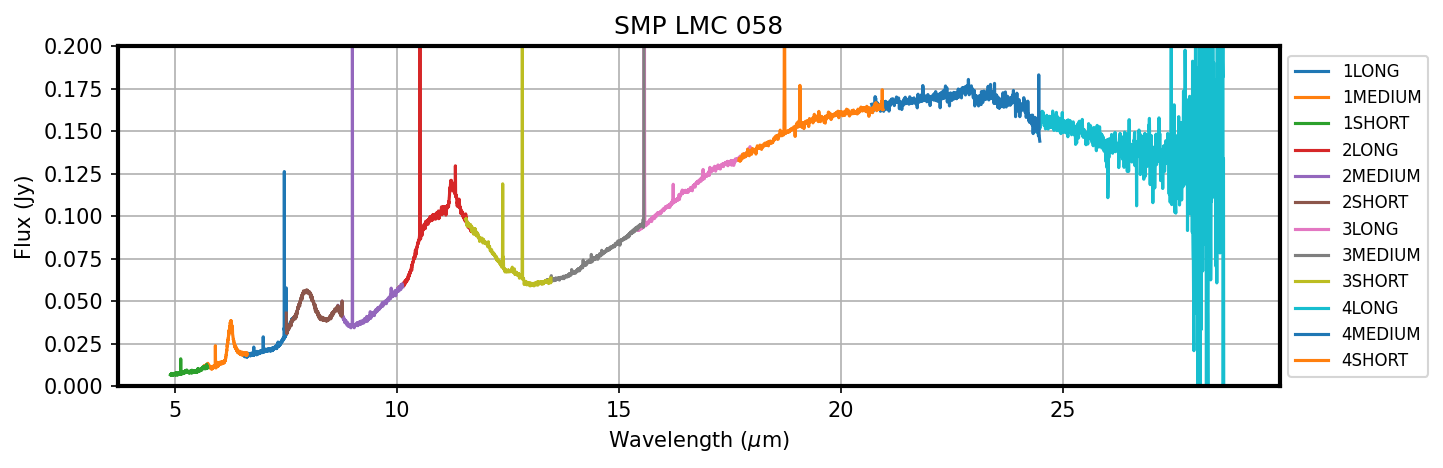

In [28]:
# Normal plots
%matplotlib inline
# Interactive plots
#%matplotlib notebook


rc('axes', linewidth=2)
fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=150)

for file in x1dfiles:
    x1d=fits.open(file)
    x1ddata=x1d[1].data
    wave=x1ddata['WAVELENGTH']
    flux=x1ddata['FLUX']
    
    # labels
    label=x1d[0].header['CHANNEL']+x1d[0].header['BAND']
    
    plt.plot(wave,flux,label=label)
    
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Flux (Jy)')
plt.title('SMP LMC 058')
plt.ylim(0,0.2)
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://www.stsci.edu/~dlaw/stsci_logo.png" alt="stsci_logo" width="200px"/> 